In [4]:
# Convolutional Neural Network in Pytorch

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

import math
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

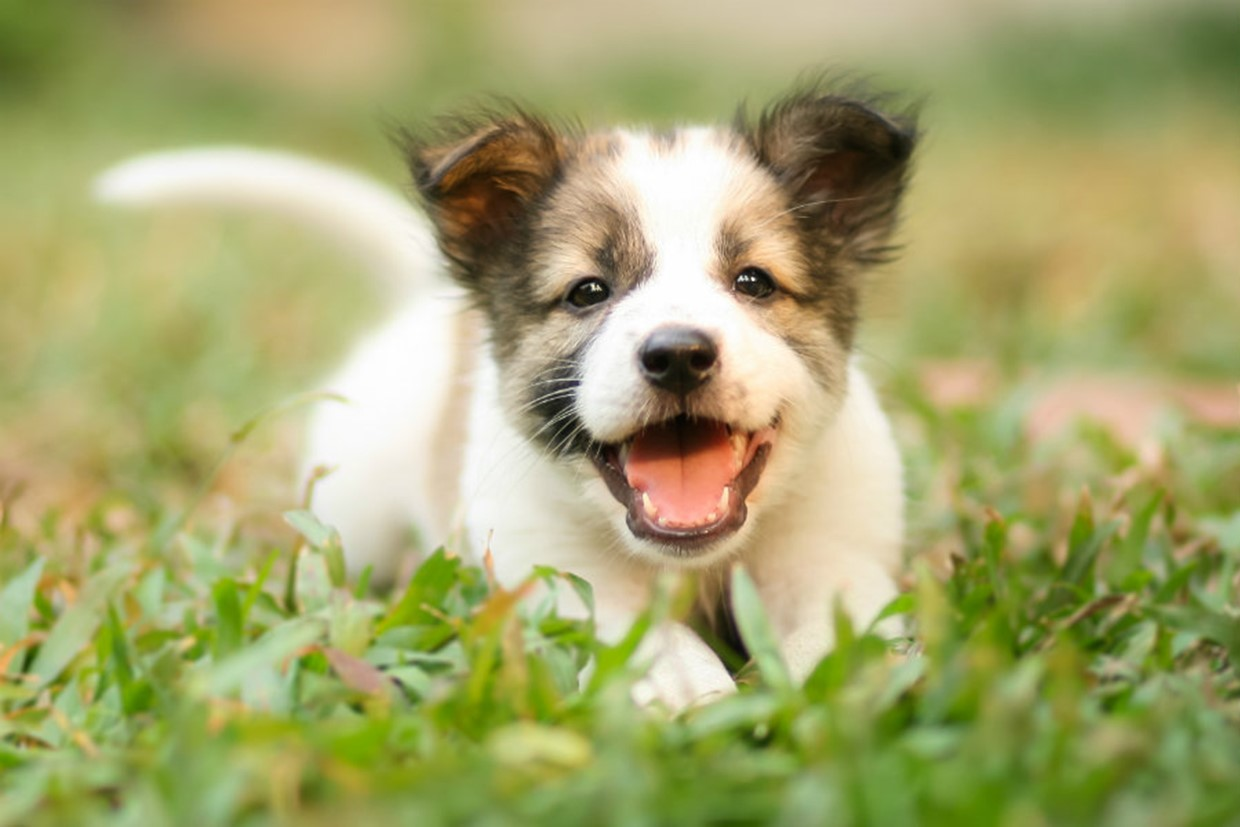

In [6]:
# Lets load a test image using Python Image Library
test_img1 = Image.open("../datasets/puppy.jpg").convert('RGB')
test_img1

In [7]:
# Lets create a Pytorch transform using torchvision
transform = T.ToTensor()
resize = T.Resize(512)
test_img1 = transform(resize(test_img1))
print("Image Shape ", test_img1.shape)
# Note: Many torchvision functions with only work on PIL Images

Image Shape  torch.Size([3, 512, 767])


In [8]:
# First we must create a filter that will extract edges on the x direction
gx = torch.FloatTensor([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
]).unsqueeze(0)
gx = torch.repeat_interleave(gx, 3, 0).unsqueeze(0)
print("Kernerl Shape ", gx.shape)
print(gx)

Kernerl Shape  torch.Size([1, 3, 3, 3])
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])


In [9]:
# Now we must create a filter that will extract edges in the y direction
gy = torch.FloatTensor([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
]).unsqueeze(0)
gy = torch.repeat_interleave(gy, 3, 0).unsqueeze(0)
print("Kernel Shape ", gy.shape)
print(gy)

Kernel Shape  torch.Size([1, 3, 3, 3])
tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])


Feature Map Shape  torch.Size([1, 1, 510, 765])


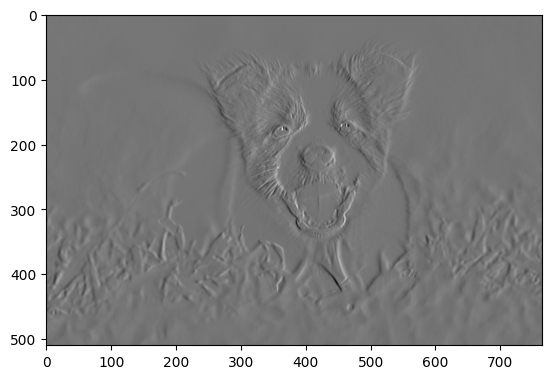

In [10]:
# Convolve the Image with the x direction kernel
conv_out1 = F.conv2d(test_img1.unsqueeze(0), gx, bias=None, stride=1)
print("Feature Map Shape ", conv_out1.shape)

_ = plt.imshow(conv_out1.squeeze(), cmap="gray")

Feature Map Shape  tensor([[[ 9.4118e-02,  9.4118e-02,  9.4118e-02,  ...,  3.0980e-01,
           3.0196e-01,  2.9804e-01],
         [ 4.7059e-02,  4.7059e-02,  4.7059e-02,  ...,  2.7843e-01,
           2.6667e-01,  2.5490e-01],
         [-3.4273e-07, -3.4273e-07, -3.4273e-07,  ...,  2.0392e-01,
           2.0000e-01,  1.9216e-01],
         ...,
         [ 3.6863e-01,  3.9216e-01,  4.3137e-01,  ..., -2.0000e-01,
          -1.8431e-01, -1.7647e-01],
         [ 3.7255e-01,  4.2353e-01,  4.7451e-01,  ..., -1.3726e-01,
          -1.4118e-01, -1.5686e-01],
         [ 4.1961e-01,  4.4706e-01,  4.9412e-01,  ..., -7.8431e-02,
          -9.0196e-02, -1.0588e-01]]])


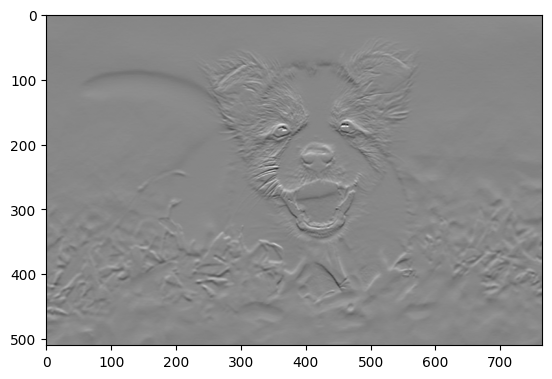

In [11]:
# Convolve the Image with the y direction kernel
conv_out2 = F.conv2d(test_img1, gy, bias=None, stride=1)
print("Feature Map Shape ", conv_out2)
_ =  plt.imshow(conv_out2.squeeze(), cmap="gray")

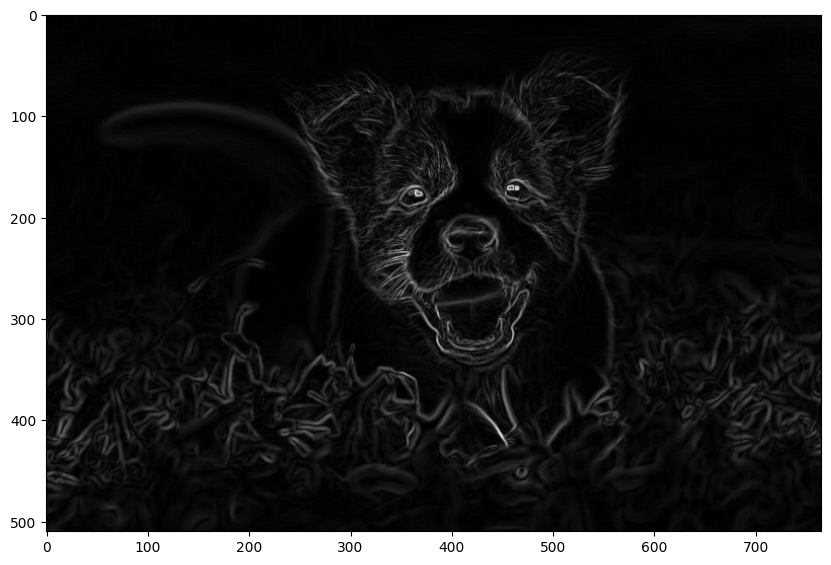

In [12]:
# Combining the two resulting images together by finding the magnitude
conv_out = (conv_out1.pow(2) + conv_out2.pow(2)).sqrt()
plt.figure(figsize=(10, 10))
_ = plt.imshow(conv_out.squeeze(), cmap="gray")

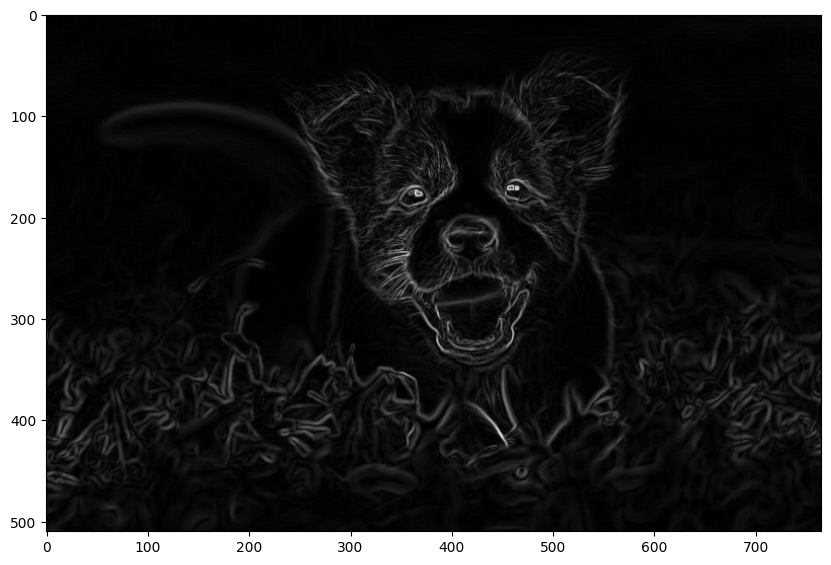

In [13]:
# Instead of doing each convolution seperatelym we can concatenate the kernels and perform both convolutions in one step

# Concatenate both kernels
g_xy = torch.concat((gx, gy), 0)

# We can perform the convolutions of both kernels in the same step
conv_out3 = F.conv2d(test_img1.unsqueeze(0), g_xy, bias=None, stride=1)

# We can now easily find the magnitude
conv_out_mag = conv_out3.pow(2).sum(1).sqrt()

# We should get the same output as before!
plt.figure(figsize=(10, 10))
_ = plt.imshow(conv_out_mag.squeeze(), cmap="gray")

In [14]:
# https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html
# torch.nn.Conv2d

# Lets create a learnable 2D convolutional layer
# in_channels  - the number of input channels
# out_channels - the number of output channels - also the number of kernels in a layer
# kernel_size  - the height and width of our kernel - can specify with a tuple for non-square kernels
# stride       - the number of pixels the kernel will "step"
# bias         - same as a linear layer, 1 bias term per output channel

conv_kernel = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)

# Define an optimizer
optimizer = optim.SGD(conv_kernel.parameters(), lr=0.01)

In [15]:
# Lets have a look at the kernel's shape
conv_kernel.weight.shape

torch.Size([1, 3, 3, 3])

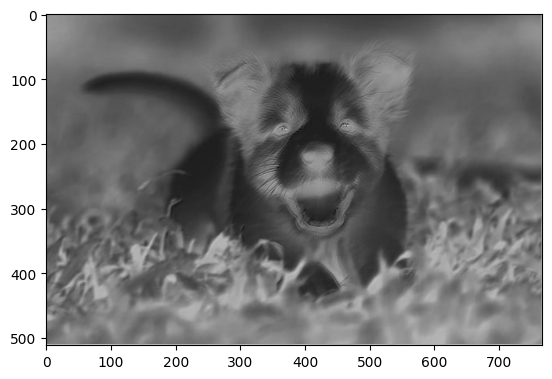

In [16]:
with torch.no_grad():
    imgs_out = conv_kernel(test_img1.unsqueeze(0))

    _ = plt.imshow(imgs_out[0, 0], cmap="gray")

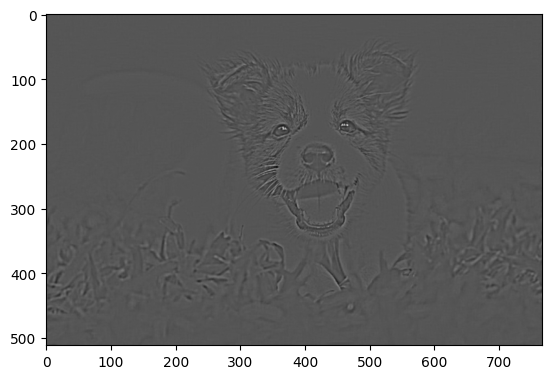

In [17]:

blur = T.GaussianBlur(7, 4)
# Blur the image and subtract this from the original
# Blurring will leave only the high frequency components on the image
# By subtracting them from the original we should get only the high frequency components
target = test_img1.unsqueeze(0) - blur(test_img1.unsqueeze(0))
_ = plt.imshow(torch.squeeze(target[0, 0]), cmap='gray')

In [18]:
# Training our kernel

logger = []

for _ in trange(1024):
    imgs_out = conv_kernel(test_img1.unsqueeze(0))

    loss = (target - imgs_out).pow(2).mean()
    logger.append(loss.item())
    conv_kernel.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 1024/1024 [00:15<00:00, 67.49it/s]


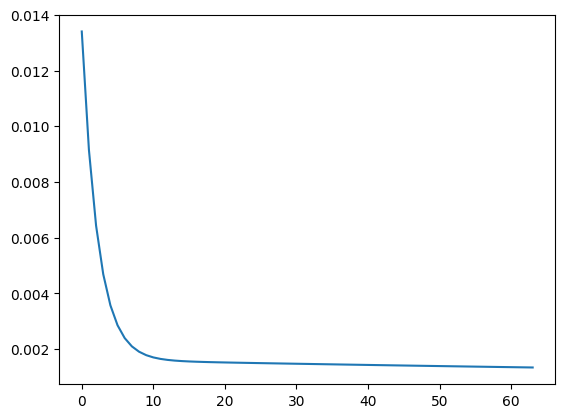

In [19]:
plt.plot(logger[:64])

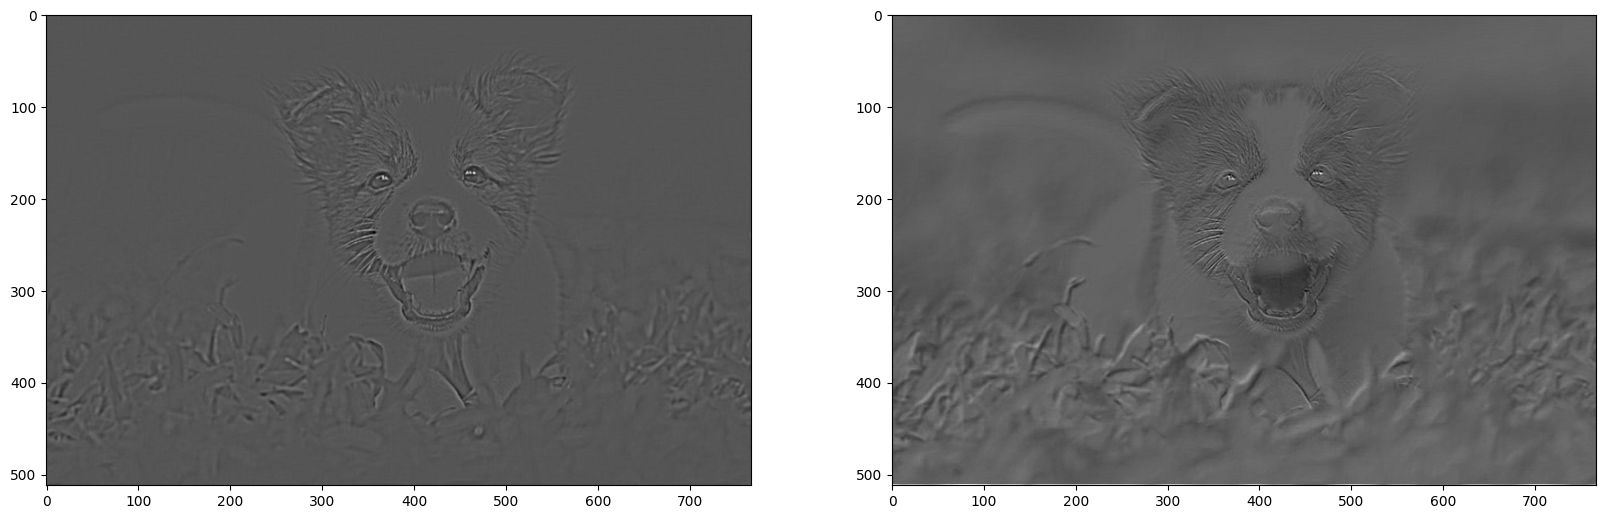

In [20]:

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,10))
ax2.imshow(torch.squeeze(imgs_out[0, 0].detach()), cmap='gray')
ax1.imshow(torch.squeeze(target[0, 0]), cmap='gray')

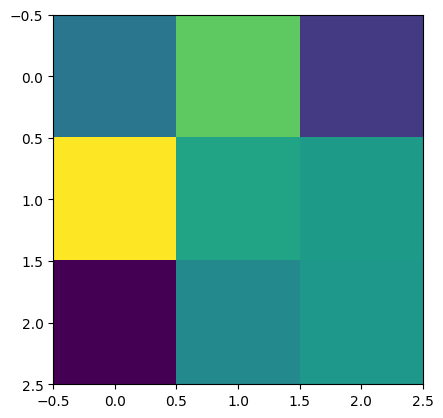

In [21]:
plt.imshow(conv_kernel.weight.data[0].mean(0).numpy())